# Importing necessary libraries

In [2]:
# !pip install openai==0.28
# !pip install spacy-lookups-data
# !pip install torch

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
from tqdm import tqdm
import time

from google.colab import drive
from os.path import join

import re
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import describe
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from scipy.special import logit, expit
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.formula.api import mnlogit
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# import cupy as cp
# import openai

# Load data

In [2]:
drive.mount('/content/drive')
PROJECT_DIR = "/content/drive/MyDrive/Thesis/Data"
FEEDBACK_DIR = join(PROJECT_DIR, "Feedback data")
PROCESSED_DIR = join(PROJECT_DIR, "Processed")

Mounted at /content/drive


Loading the AB feedback dataset with predicted topics:

In [25]:
prediction_dataset = pd.read_csv(join(PROCESSED_DIR, "ab_predicted_final.csv"), encoding='latin1')

Loading the dataset with manually coded
 data and whole Ab_feedback for further processing:



In [26]:
manually_coded = pd.read_csv(join(PROJECT_DIR, "Annotation data/manual_coding_majority_vote_2000_(emotionality_recoding).csv"), encoding='latin1')
ab_text_feedback = pd.read_csv(join(FEEDBACK_DIR, "ab_selected_feedback_data.csv"), encoding='latin1')

Loading the AB items

In [27]:
ab_items = pd.read_csv(join(FEEDBACK_DIR,"ab_items.csv"), encoding='latin1')

# Preprocessing

## Preparing prediction dataset
In this part we combine our manually encoded data with data that we encoded automatically using the transformers model

Prepare the manually coded data to be joined back in:


In [28]:
# Filter rows where global_id is in manually_coded
manually_coded_extra_info = ab_text_feedback[ab_text_feedback['global_id'].isin(manually_coded['global_id'])]

# Merge tables based on the 'global_id' column
col = ['global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'emo_une']

manually_coded_combi = pd.merge(manually_coded_extra_info.iloc[:, [0, 1, 3, 4, 5, 6, 7, 8]],
                                manually_coded.loc[:, col],
                                on='global_id')

# Tidy up the dates
manually_coded_combi.loc[:, 'date_left'] = pd.to_datetime(manually_coded_combi['date_left'].str.slice(stop=-6), format='%b %d, %Y', errors='coerce').dt.date


Join the prediction and manually coded subset:


In [29]:
prediction_dataset['origin'] = "prediction"
manually_coded_combi['origin'] = "manual"

predicition_merged = pd.concat([manually_coded_combi, prediction_dataset], axis=0)

In [30]:
predicition_merged.head()

,seller,date_left,comment,itemid,price,rating,category,global_id,t_communication,t_payment,...,t_price,t_value,t_shipping,t_product,t_feedback,t_vendor,t_generic,t_overall,emo_une,origin
0,HumboldtFarms,2016-07-01,Best vendor. Amazing Quality. Stealth on point...,98213.0,67.0,Positive,Cannabis & Hashish,ao978412,0,0,...,0,0,1,1,0,1,0,0,1,manual
1,HumboldtFarms,2017-04-29,"ordered 5 carts, got only one full one all the...",30006.0,97.0,Neutral,Cannabis & Hashish,ao2200726,1,0,...,0,1,1,1,0,0,0,0,0,manual
2,HumboldtFarms,NaT,"Very bad communication, wax looked nothing lik...",29993.0,37.0,Negative,Cannabis & Hashish,ao2229907,1,0,...,0,0,0,1,0,0,0,0,1,manual
3,HumboldtFarms,2016-07-31,Fast shipping and great product,29989.0,82.0,Positive,Cannabis & Hashish,ao975350,0,0,...,0,0,1,1,0,0,0,0,0,manual
4,HumboldtFarms,2016-11-02,"Fast shipping, great stealth",67532.0,72.0,Positive,Cannabis & Hashish,ao963906,0,0,...,0,0,1,0,0,0,0,0,0,manual


Let's check if all values have categories:

In [31]:
num = predicition_merged['category'].isna().sum()
percentage = (predicition_merged['category'].isna().sum() / predicition_merged.shape[0]) * 100
print(f"Number of missing values in category: {num} ({percentage:.2f}%)")

Number of missing values in category: 571 (0.05%)


In [32]:
predicition_merged[predicition_merged['category'].isna()]['origin'].unique()

array(['manual'], dtype=object)

So this means that 1/4 of the data that was used for manual coding did not have a category.

Change type of columns

In [33]:
# Define the columns to convert
cols_to_convert = predicition_merged.columns[8:20]

# Function to convert to Int64 if the value is finite, otherwise keep NaN
def to_int_if_finite(series):
    return series.apply(lambda x: int(x) if pd.notna(x) and np.isfinite(x) else pd.NA).astype('Int64')

# Apply the conversion to the specified columns with a progress bar
for col in tqdm(cols_to_convert, desc="Converting columns in full_dataset"):
    predicition_merged[col] = to_int_if_finite(predicition_merged[col])

Converting columns in full_dataset: 100%|██████████| 12/12 [00:29<00:00,  2.43s/it]


## Preprocessing AB_items


### Shipping

In [34]:
# Normalize 'shipsfrom' column
ab_items['shipsfrom'] = ab_items['shipsfrom'].str.strip().str.title()

# Function to split and clean 'shipsto' column
def normalize_shipsto(value):
    if pd.isna(value):
        return []
    regions = value.split(',')
    normalized_regions = [region.strip().title() for region in regions]
    return normalized_regions

# Apply normalization function to 'shipsto' column
ab_items['shipsto_normalized'] = ab_items['shipsto'].apply(normalize_shipsto)

# Function to determine shipping category
def determine_shipping_category(row):
    shipsfrom = row['shipsfrom']
    shipsto_list = row['shipsto_normalized']

    # If 'Worldwide' is in shipsto, return 'Worldwide'
    if 'Worldwide' in shipsto_list:
        return 'Worldwide'

    is_domestic = any(shipsto == shipsfrom for shipsto in shipsto_list)
    is_international = any(shipsto != shipsfrom for shipsto in shipsto_list)

    # Determine category based on shipsto contents
    if is_domestic and not is_international:
        return 'Domestic'
    elif is_international:
        return 'International'
    return 'Unknown'

# Apply the function to determine shipping category
ab_items['shipping_category'] = ab_items.apply(determine_shipping_category, axis=1)

# Drop the 'shipsto_normalized' column
ab_items.drop(columns=['shipsto_normalized'], inplace=True)

In [35]:
ab_items.head()

,itemid,seller,name,description,class,quantityleft,endsin,shipsfrom,shipsto,payment,...,cat1,cat2,cat3,shipping_is_0,date_le,n_sold,since,vendor_level,trust_level,shipping_category
0,20,firedr0ne,AMAZON REFUND - 50GBP FIXED PRICE FAST RELIABLE |,I have an associate who is currently working a...,Digital goods,Unlimited,Never,Panama,Worldwide,Escrow,...,Services,Other,Other,1.0,2017-06-13,1.0,2014-12-21,1.0,5.0,Worldwide
1,22,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Fraud,Other,Other,1.0,2017-06-13,0.0,2014-12-21,1.0,4.0,Worldwide
2,23,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Guides & Tutorials,Fraud,Fraud,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide
3,24,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Digital Products,Fraud Software,Fraud Software,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide
4,25,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Guides & Tutorials,Other,Other,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide


### Other steps

We can delete some column

In [36]:
ab_items.drop(columns=['endsin', 'shipsfrom', 'shipsto'], inplace=True)


Find itemid values that occur more than once


In [37]:
duplicate_itemids = ab_items['itemid'].value_counts()[ab_items['itemid'].value_counts() > 1].index
print("Number of itemid values that occur more than once:", len(duplicate_itemids))

# Filter the DataFrame based on these itemid values
duplicate_records = ab_items[ab_items['itemid'].isin(duplicate_itemids)]

Number of itemid values that occur more than once: 80


In [38]:
# Function to compare rows of a DataFrame and return columns with differences
def compare_rows(df):
    differences = []
    for col in df.columns:
        if df[col].nunique() > 1:
            differences.append(col)
    return differences

# Lists to store itemid values
all_same = []
some_different = []

# List to store the comparison results
comparison_results = []

# Iterate over each duplicate itemid and compare rows
for itemid in duplicate_itemids:
    subset = duplicate_records[duplicate_records['itemid'] == itemid]
    differences = compare_rows(subset)

    if differences:
        some_different.append(itemid)
        for col in differences:
            row = {'itemid': itemid, 'different_column': col}
            unique_values = subset[col].unique()
            for idx, value in enumerate(unique_values):
                row[f'instance_{idx+1}'] = value
            comparison_results.append(row)
    else:
        all_same.append(itemid)

# Convert the results to a DataFrame
comparison_df = pd.DataFrame(comparison_results)


In [39]:
comparison_df

,itemid,different_column,instance_1,instance_2
0,315499,price,21.48,0.00
1,56999,price,82500.00,49000.00
2,56994,price,82500.00,49000.00
3,26568,price,537.06,2148.25
4,316103,price,0.00,16.11
5,61038,price,999.00,1000.00
6,315644,price,0.00,13.88
7,6153,price,2.00,1.00
8,346723,price,1800.00,1500.00
9,357744,price,150.00,0.00


Since all records differ only in price and I take into account the price from the second database, we can source these duplicates


In [40]:
# remove duplicates from database with items
ab_items = ab_items.drop_duplicates(subset=['itemid'], keep='first')

## Preparing: AB full dataset

First we need to verify if we don't have diplicates records:

In [41]:
duplicates = predicition_merged[predicition_merged.duplicated(subset=['itemid', 'seller'], keep=False)]

In [42]:
unique_seller_check = predicition_merged.groupby('itemid')['seller'].nunique()

# Filtering out itemids with more than one unique seller
unique_seller_check[unique_seller_check > 1]


itemid
3561.0      2
122818.0    2
318397.0    2
Name: seller, dtype: int64

Following 3 items have 2 sellers -> they are the same sellers but cotains extra "\x83Â\x82Ã...."

3561.0      
122818.0    
318397.0


In [43]:
predicition_merged[predicition_merged['itemid'] == 122818.0]['seller'].unique()

array(['PoliceÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â

Let's normalize these names:

In [44]:
# Find itemids with more than one unique seller
unique_seller_check = predicition_merged.groupby('itemid')['seller'].nunique()
non_unique_itemids = unique_seller_check[unique_seller_check > 1].index

# For each itemid with more than one unique seller, replace all sellers with the first seller's name
for itemid in non_unique_itemids:
    # Get all unique sellers for the given itemid
    sellers = predicition_merged[predicition_merged['itemid'] == itemid]['seller'].unique()

    if len(sellers) > 1:
        # Get the first seller's name
        first_seller = sellers[0]

        # Replace all sellers with the first seller's name for the given itemid
        predicition_merged.loc[predicition_merged['itemid'] == itemid, 'seller'] = first_seller

# Check the results to ensure the changes have been applied
unique_seller_check_after = predicition_merged.groupby('itemid')['seller'].nunique()
non_unique_itemids_after = unique_seller_check_after[unique_seller_check_after > 1]
print("\nItemIDs with more than one unique seller after processing (should be empty):")
print(non_unique_itemids_after)


ItemIDs with more than one unique seller after processing (should be empty):
Series([], Name: seller, dtype: int64)


In [45]:
# Convert 'itemid' columns to string
ab_items.loc[:,'itemid'] = ab_items['itemid'].astype(int)
predicition_merged.loc[:,'itemid'] = predicition_merged['itemid'].astype(int)

Merge two dataset:

In [46]:
col_to_merge = ['itemid', 'name', 'class', 'payment', 'cat1', 'cat2', 'cat3',
                'date_le', 'n_sold', 'since', 'vendor_level',
                'trust_level', 'shipping_category']

# Merge the entire datasets based on 'itemid'
ab_full = pd.merge(predicition_merged,
                   ab_items[col_to_merge],
                   on=['itemid'],
                   how='left')

In [47]:
ab_full.shape

(1219944, 33)

Save the file

In [48]:
ab_full.to_csv(join(PROCESSED_DIR, "full_dataset.csv"), index=False)

## Preparing AB drugs & chemicals dataset

### Filtering categories

Firs we need to filter our data - I will focus only 'Drugs & Chemicals' categories (e.g., weed, hash, cocaine, MDMA, meth; also including prescription medicine and supplements) but I will excluding precursors or any paraphernalia

In [49]:
ab_full_drugs = ab_full[(ab_full['cat1'] == 'Drugs & Chemicals') & (~ab_full['cat2'].isin(['Other', 'Weight Loss', 'Tobacco','Paraphernalia']))]

Let's check the combination of columns:

In [50]:
value_counts = ab_full_drugs[['cat2', 'cat3']].value_counts()

value_counts_df = value_counts.reset_index(name='count')

sorted_df = value_counts_df.sort_values(by=['cat2', 'count'], ascending=[True, False])
sorted_df

,cat2,cat3,count
2,Benzos,Pills,72445
25,Benzos,Other,5686
29,Benzos,Powder,3880
40,Benzos,RC,859
0,Cannabis & Hashish,Buds & Flowers,192461
4,Cannabis & Hashish,Concentrates,51966
12,Cannabis & Hashish,Hash,33727
14,Cannabis & Hashish,Edibles,21765
18,Cannabis & Hashish,Other,13728
24,Cannabis & Hashish,Shake,6352


In [51]:
ab_full_drugs['category'].value_counts()

category
Cannabis & Hashish    324481
Stimulants            202472
Ecstasy               119763
Opioids               104885
Psychedelics           96870
Benzos                 82870
Prescription           37667
Dissociatives          30639
Steroids               20153
Name: count, dtype: int64

In [52]:
ab_full_drugs.dtypes

seller                object
date_left             object
comment               object
itemid               float64
price                float64
rating                object
category              object
global_id             object
t_communication        Int64
t_payment              Int64
t_refund               Int64
t_price                Int64
t_value                Int64
t_shipping             Int64
t_product              Int64
t_feedback             Int64
t_vendor               Int64
t_generic              Int64
t_overall              Int64
emo_une                Int64
origin                object
name                  object
class                 object
payment               object
cat1                  object
cat2                  object
cat3                  object
date_le               object
n_sold               float64
since                 object
vendor_level         float64
trust_level          float64
shipping_category     object
dtype: object

In [53]:
ab_full_drugs.isna().sum()

seller                   0
date_left            15771
comment                  0
itemid                   0
price                    0
rating                   0
category                 0
global_id                0
t_communication          0
t_payment                0
t_refund                 0
t_price                  0
t_value                  0
t_shipping               0
t_product                0
t_feedback               0
t_vendor                 0
t_generic                0
t_overall                0
emo_une                  0
origin                   0
name                     0
class                    0
payment                  0
cat1                     0
cat2                     0
cat3                     0
date_le                  0
n_sold               48824
since                48824
vendor_level         48824
trust_level          48824
shipping_category        0
dtype: int64

### Weights: GPT 3.5


Read sample dataset

In [ ]:
weight_manual_sample = pd.read_excel(join(PROJECT_DIR,"Annotation data/weight_manual_sample.xlsx"))

Take from our main dataset specific columns:

In [ ]:
df_weight = ab_full_drugs[['name', 'itemid']].drop_duplicates(subset=['itemid'])
df_weight.shape

(45523, 2)

remove records which are in our smaple dataset - sample data have 400 records

In [ ]:
df_weight = df_weight[~df_weight['itemid'].isin(weight_manual_sample['itemid'])]

GPT 3.5 turbo

In [ ]:
openai.api_key = 'sk-' # change to your private API Key

def extract_weight(description):
    prompt = f"""
    Extract the total weight in grams from the following product description, considering all possible product quantities and measurements.
    Respond only with the total weight in grams.

    Examples:
    1. '2x White JigSaw 220 MG MDMA NETTO labtested' should be interpreted as 2 products each 220 mg, so the total weight is 0.44 grams.
    2. 'White Powder 500 GRAM' should be interpreted as 1 product of 500 g, so the total weight is 500 grams.
    3. 'Viagra (Sildenafil) 10 x 150Miligram' should be interpreted as 10 products each 150 mg, so the total weight is 1.5 grams.
    4. 'Custom Listing for icebox***1- PINT★PURPLE DRANK★LEAN ★PHARMA GRADE★' does not specify a weight, so it should be ignored.
    5. '25gr BUBLE GUM --MEDICINAL GRADE-- TYPE INDICA 75%' should be interpreted as 25 grams.
    6. 'skunk/og kush 1oz' should be interpreted as 1 ounce, so the total weight is 28.3495 grams.
    7. '1KG Isopropylphenidate' Should be interpreted as 1 kg so the total weight is 1000 g.
    8. '2CB Caps X 5 **22 MG Each 97 % + Purity (Sample Pack) Full Escrow' should be interpreted as 0.11 grams.
    9. 'GHB 10 ml Straight from the lab.' does not specify a weight, so it should be ignored.
    10. '120 Pills Ativan 5 MG' should be interpreted as 120 pills each 5 mg, so the total weight is 0.6 grams.
    11. '<U+25BA><U+2605> 4 <U+2606> MDM <U+2605> 50mg <U+2606> High Quality <U+2605> Reagent Tested' should be interpreted as 4 products each 50 mg, so the total weight is 0.2 grams.
    12. '**** 2G ***** WHITE NIGHTMARE **** $$ IC $$' should be interpreted as 2 grams.
    13. '5 Blotters 200Âµg' should be interpreted as 5 prodcuts each 200 micrograms, so the total weight is 0.001 grams.
    14. 'GHB 20 ml of cannabis' does not specify a weight but refers to volume, so it should be ignored.
    15. '2 Green Tesla' does not specify a weight, so it should be ignored.
    16. 'Lorazepam 8mg' should be interpreted as 0.008 grams.
    17. '50ug LSD premium' should be interpreted as 50 mikrograms which is 0.00005 grams.
    18. 'Codalgin forte - slab of 10 pills' does not specify a weight, so it should be ignored.
    19. '10x 10/325 NORCO HYDROCODONE' contains 10 tablets, each with 10 mg of hydrocodone and 325 mg of acetaminophen, so the total weight is 3.35 grams.
    20. '50x LSD 155ug LSD - 98%+ Pure Aztec Crystal' contains 50 products, each with 155 ug which are micrograms, so the totla is 0.00775 grams.
    Description: '{description}'
    """

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0125",

        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    response_text = response['choices'][0]['message']['content'].strip()
    response_text = response_text.lower().strip()
    if any(phrase in response_text for phrase in ["cannot be determined", "should be ignored", "not specify a weight", "not specified", "not contain any weight"]):
        return 0.0
    else:
        # Find all matches to grams in response
        grams_matches = re.findall(r"(\d*[\.,]?\d+)\s*(g|gram|grams)\b", response_text)

        if grams_matches:
            # Choose the last match for grams
            last_match = grams_matches[-1]
            weight_str = last_match[0].replace(',', '.')
            weight_in_grams = float(weight_str)
        else:
            # Find all matches to milligrams in response if grams not found
            mg_matches = re.findall(r"(\d*[\.,]?\d+)\s*(mg|milligram|milligrams)\b", response_text)

            if mg_matches:
                # Choose the last match for milligrams
                last_match = mg_matches[-1]
                weight_str = last_match[0].replace(',', '.')
                weight_in_mg = float(weight_str)
                # Convert milligrams to grams
                weight_in_grams = weight_in_mg / 1000
            else:
                weight_in_grams = 0.0

            # Format the weight based on the conditions
        if weight_in_grams >= 1:
            weight_in_grams = round(weight_in_grams, 2)

        return weight_in_grams

In [54]:
def process_batches(data, batch_size):
    for start in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
        end = min(start + batch_size, len(data))
        data.loc[start:end-1, 'predicted_weight'] = data.loc[start:end-1, 'name'].apply(extract_weight)
        # after processing each batch save data to file:
        data.to_csv(join(PROCESSED_DIR, "ab_drugs_weight.csv"), index=False)
        print(f"Processed batch {start // batch_size + 1}, saved")
        time.sleep(55)

Check my model on sample  coded data:


In [ ]:
process_batches(weight_manual_sample, batch_size=200)

Check the accuracy of my model:

In [ ]:
weight_manual_sample['match'] = weight_manual_sample['weight_manual'] == weight_manual_sample['predicted_weight']
accuracy = weight_manual_sample['match'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.00%


In [ ]:
weight_manual_sample[weight_manual_sample['match']== False]

,itemid,name,weight_manual,predicted_weight,match
3,156173,Custom Listing imedic |,0.0000,1486.20000,False
11,131109,"10x Roxicodone 30mg A215 USP, EXPRESS ONLY *FE...",0.3000,3.00000,False
12,319755,OxyMorphone - 30mg - Brown (generic Opana) 2 f...,0.0300,0.06000,False
26,284059,<U+2605><U+2605><U+2605> Galenika Bensedin (Di...,0.1500,1.50000,False
40,301898,Suboxone 8mg/2mg sublingual strips!!!! Kick t...,0.0080,0.01000,False
72,124146,GHB 50 ml Straight from the lab. |,0.0000,50.00000,False
75,13628,LB Blue Dream A++ Cali Outdoor |,453.5900,0.00000,False
80,256196,"norco/ vics 10/325mg, yellow (v3601) x15~$12 p...",4.8750,5.03000,False
88,274820,<U+2622> <U+2622>8 ball of fiscale coke<U+2622...,0.0000,3.50000,False
94,274080,10 x Pfizer xanax 2mg bar (alprazolam) |,0.0200,20.00000,False


Process whole dataset:

In [ ]:
process_batches(df_weight, batch_size = 200)

Processing batches:   0%|          | 0/3 [00:00<?, ?it/s]

Processed batch 219, saved results


Processing batches:  33%|███▎      | 1/3 [03:52<07:44, 232.41s/it]

Processed batch 220, saved results


Processing batches:  67%|██████▋   | 2/3 [06:48<03:19, 199.28s/it]

Processed batch 221, saved results


Processing batches: 100%|██████████| 3/3 [08:08<00:00, 162.92s/it]


Add results to the main dataset:

In [ ]:
weight_manual_sample['weight_origin'] = 'manual'
df_weight['weight_origin'] = 'predicted'

In [ ]:
df_weight.rename(columns={'predicted_weight': 'weight_in_gram'}, inplace=True)
weight_manual_sample.rename(columns={'weight_manual': 'weight_in_gram'}, inplace=True)

df_weight_total = pd.concat([df_weight, weight_manual_sample])

In [ ]:
ab_full_drugs = pd.merge(ab_full_drugs, df_weight_total[['itemid', 'weight_in_gram', 'weight_origin']], on='itemid', how='left')

Save to new file:

In [ ]:
# ab_full_drugs.to_csv(join(PROCESSED_DIR, "ab_drugs_dataset_with_weight.csv"), index=False)

### Cleaning data

In [79]:
ab_full_drugs = pd.read_csv(join(PROCESSED_DIR,"ab_drugs_dataset_with_weight.csv"), encoding='latin1')

####Shipping is Uknown

In [80]:
ab_full_drugs[ab_full_drugs['shipping_category']=='Unknown']['category'].value_counts()

category
Opioids       6
Stimulants    1
Name: count, dtype: int64

We have only 7 value where shipping is unknown, so we can delete these records:

In [81]:
ab_full_drugs = ab_full_drugs[ab_full_drugs['shipping_category'] != 'Unknown']

#### Weight cleaning

Some of our data have weight = 0 -> names of this products are for example: 'Custom listing...", "	tip jar", "SAMPLE" <br>

we don't use this records:

In [82]:
ab_full_drugs['weight_in_gram'] = ab_full_drugs['weight_in_gram'].astype(str).replace(',', '.', regex=True).astype(float)

In [83]:
print(f"Number of records where 'weight_in_gram' is 0:", ab_full_drugs[ab_full_drugs['weight_in_gram']==0].shape[0])
print(f"Number of unique 'itemid' where 'weight_in_gram' is 0:", ab_full_drugs[ab_full_drugs['weight_in_gram']==0].drop_duplicates(subset=['itemid']).shape[0])

Number of records where 'weight_in_gram' is 0: 57171
Number of unique 'itemid' where 'weight_in_gram' is 0: 5004


In [84]:
# Calculate the percentage of records where weight_in_gram is 0 in the entire DataFrame
percentage_zero_weight = (ab_full_drugs[ab_full_drugs['weight_in_gram'] == 0].shape[0] / ab_full_drugs.shape[0]) * 100
print(f"Percentage of records where 'weight_in_gram' is 0 in the entire DataFrame: {percentage_zero_weight:.2f}%")
print("--------------------------------------------------------------------------------------------------------------")
# Calculate the percentage of records where weight_in_gram is 0 within each category
percentage_zero_weight_by_category = (ab_full_drugs[ab_full_drugs['weight_in_gram'] == 0]['category'].value_counts() / ab_full_drugs['category'].value_counts()) * 100
print("Percentage of records where 'weight_in_gram' is 0 within each category:")
print(percentage_zero_weight_by_category)


Percentage of records where 'weight_in_gram' is 0 in the entire DataFrame: 5.61%
--------------------------------------------------------------------------------------------------------------
Percentage of records where 'weight_in_gram' is 0 within each category:
category
Benzos                 3.201400
Cannabis & Hashish     8.206952
Dissociatives          7.190182
Ecstasy                3.452652
Opioids                4.765492
Prescription           5.309688
Psychedelics           7.759884
Steroids              13.223838
Stimulants             2.158334
Name: count, dtype: float64


In [85]:
ab_full_drugs[ab_full_drugs['weight_in_gram']==0][['name','price']].sample(70)

,name,price
890022,#### PROMOTION #### FREE XTC + HIGH QUALITY ...,149.21
56068,Sample Pack 3x Types Of Heroin (Exclusive) |,7.86
845416,Cannatonic crossed with charlotte's web very h...,32.51
926425,Furanylfentanyl nasal spray 15 ml |,50.00
892120,"New Strain!!! ------ Golden Goat - Indoor, $55...",565.00
...,...,...
88907,Inactive |,31.67
853895,1mL THC Distillate Vape Cartidge 100 pack. |,2010.00
189631,"LIQUID MUSHROOMS [Pure Psilocybin] No Nausea, ...",23.33
59003,Sample White Colombian A1 Cocaine Labtested 93...,9.04


In [86]:
ab_full_drugs = ab_full_drugs[ab_full_drugs['weight_in_gram'] != 0]

In [87]:
ab_full_drugs.shape[0]

962622

#### Grouping of variables

In [90]:
unique_itemid_seller = ab_full_drugs.drop_duplicates().groupby('itemid')['seller'].nunique()

# Check if all itemid have only one unique seller
all_single_seller = (unique_itemid_seller == 1).all()

all_single_seller

True

Remove Null value in vendor trust & trust level:

In [91]:
ab_full_drugs.reset_index(drop=True, inplace=True)
ab_full_drugs = ab_full_drugs.dropna(subset=['vendor_level', 'trust_level'])

Create 4 group for payment:

In [92]:
ab_full_drugs['payment'].value_counts()

payment
Escrow             519161
FE Listing 100%    345791
FE Listing 50%      24182
FE Listing 90%      12145
FE Listing 70%       3871
FE Listing 40%       3314
FE Listing 80%       3187
FE Listing 20%       1923
FE Listing 30%       1261
FE Listing 60%        991
FE Listing 10%         18
Name: count, dtype: int64

In [93]:
def assign_group(category):
    if '100%' in category:
        return ' FE Listing 100%'
    elif 'FE Listing' in category and '100%' not in category:
        return 'FE Listing 50-90%' if int(category.split()[-1][:-1]) >= 50 else 'FE Listing 10-40%'
    else:
        return 'Escrow'

# Przypisywanie grup
ab_full_drugs.loc[:,'payment_group'] = ab_full_drugs['payment'].apply(assign_group)

In [94]:
ab_full_drugs['payment_group'].value_counts()

payment_group
Escrow               519161
 FE Listing 100%     345791
FE Listing 50-90%     44376
FE Listing 10-40%      6516
Name: count, dtype: int64

Merging group for trust_level i vendor_level:

In [95]:
ab_full_drugs['vendor_level'].value_counts()

vendor_level
8.0     197104
7.0     163309
9.0     151346
6.0     113880
5.0      87414
10.0     80261
4.0      37109
1.0      29787
3.0      28931
2.0      26703
Name: count, dtype: int64

In [96]:
ab_full_drugs['trust_level'].value_counts()

trust_level
6.0     275761
5.0     176347
7.0     162504
8.0     122544
4.0      77150
10.0     67855
9.0      23943
3.0       9719
2.0         21
Name: count, dtype: int64

In [97]:
ab_full_drugs['vendor_level_grouped'] = ab_full_drugs['vendor_level'].apply(
    lambda x: 'Low' if x in range(1, 4) else 'Medium' if x in range(4, 7) else 'High' if x in range(7, 10) else 'Highest'
)

ab_full_drugs['trust_level_grouped'] = ab_full_drugs['trust_level'].apply(
    lambda x: 'Low' if x in range(1, 4) else 'Medium' if x in range(4, 7) else 'High' if x in range(7, 10) else 'Highest'
)

In [98]:
ab_full_drugs['vendor_level_grouped'].value_counts()

vendor_level_grouped
High       511759
Medium     238403
Low         85421
Highest     80261
Name: count, dtype: int64

In [99]:
ab_full_drugs['trust_level_grouped'].value_counts()

trust_level_grouped
Medium     529258
High       308991
Highest     67855
Low          9740
Name: count, dtype: int64

#### Price >10k

I will filter out all items with a sales price greater than $10,000 from the analysis.


*Such items are rare, and tend to more often reflect a technique
used by vendors discourage customers from buying a specific out-of-stock item, without removing the listing
(and thus discarding the reputational data associated with it)*

https://www.euda.europa.eu/document-library/eu-focused-analysis-drug-supply-alphabay-marketplace_en

In [100]:
filtered_drugs_10k = ab_full_drugs[ab_full_drugs['price'] > 10000][['seller','itemid', 'name', 'category','cat3','n_sold','weight_in_gram', 'price','rating']]

In [101]:
filtered_drugs_10k.shape[0]

175

check how many unique products we have:

In [102]:
filtered_drugs_10k['itemid'].nunique()

75

In [103]:
filtered_drugs_10k['seller'].value_counts()

seller
goombashop              22
WashingCannabisCo       19
LeftCoastEnV            18
Pasitheas               10
MeGrimlock              10
XanaxKing2              10
Zerthebest               7
XanaxLabs                6
BenzoChems               6
PillManRoxi              5
RcQueen                  5
teslaboy                 4
MrSuperMario             4
NahNah                   4
PremierPills             3
FENTSTORE                3
DutchMasters             3
captainchronic           3
ChurchOfCannabis         2
Spotmebro                2
DUTCHBULK                2
xanxanman                2
LionHGH                  2
AlpraKing                2
landedgypsie             2
lookidan3                1
TheCandyHouse            1
AusKing                  1
goingpostal              1
RainbowSunshineLSD       1
Yourdrug                 1
DrMDMA                   1
SeeBuyFly                1
ganeshuk                 1
TheMailMan               1
banditbrothersreborn     1
GucciBars            

Filtering transaction which where made as a private for specific customer:

In [104]:
filtered_drugs_10k[(filtered_drugs_10k['name'].str.contains('|'.join(['custom', 'Private', 'Something special']), case=False))]

,seller,itemid,name,category,cat3,n_sold,weight_in_gram,price,rating
354881,landedgypsie,287843,Afghan # 4 Heroin 86gr IMPORTED UNCUT and STRO...,Opioids,Heroin,1.0,86.00,10565.00,Positive
589652,DutchMasters,304930,250gr Cocaine + 5000 x mix 200+mg pills - Cust...,Stimulants,Cocaine,1.0,250.00,17725.39,Positive
685538,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685540,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685555,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685561,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685595,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685604,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive
685608,goombashop,96092,"5 lbs customers choice, any 2000$ lb strains! |",Cannabis & Hashish,Buds & Flowers,46.0,2267.96,10750.00,Positive
685615,goombashop,155280,10 lbs customers choice |,Cannabis & Hashish,Buds & Flowers,19.0,4500.00,18000.00,Positive


In [105]:
to_delete = filtered_drugs_10k[(filtered_drugs_10k['name'].str.contains('|'.join(['custom', 'Private', 'Something special']), case=False))]
to_delete.shape[0]

31

In [106]:
to_delete['rating'].value_counts()

rating
Positive    30
Negative     1
Name: count, dtype: int64

In [107]:
filtered_drugs_10k[filtered_drugs_10k['itemid'].isin(to_delete['itemid'])==True].drop_duplicates(subset=['itemid']).shape[0]

12

In [108]:
ab_full_drugs = ab_full_drugs[~ab_full_drugs['itemid'].isin(to_delete['itemid'].tolist())]
ab_full_drugs.shape

(915794, 38)

So we removed 31 records (12 individual products) that have a price above $10k  and were sold as private offers. Lets check the rest of data:

In [109]:
filtered_drugs_10k[filtered_drugs_10k['itemid'].isin(to_delete['itemid'])==False].drop_duplicates(subset=['itemid'])

,seller,itemid,name,category,cat3,n_sold,weight_in_gram,price,rating
800,XanaxKing2,317392,Oxycodone 30mg A/215 60000X for $48000 |,Opioids,Pills,1.0,1800.0000,48000.00,Positive
44061,ganeshuk,93377,SAMPLE 0.25G 4MMC/Mephedrone |,Stimulants,Other RCs,71.0,0.2500,11208.65,Positive
152615,AusKing,55573,1000 IMPORT GREEN HEARTS 170mg MDMA PILLS |,Ecstasy,Pills,1.0,170.0000,10917.46,Positive
220152,LeftCoastEnV,141646,500 Grams - FISHSCALE COLOMBIAN COCAINE - DIS...,Stimulants,Cocaine,12.0,500.0000,16897.00,Positive
221197,LeftCoastEnV,92557,250 GRAMS - FISHSCALE COLOMBIAN COCAINE - DISC...,Stimulants,Cocaine,116.0,250.0000,10050.00,Positive
...,...,...,...,...,...,...,...,...,...
941000,ChurchOfCannabis,235095,10 Lbs of the best! |,Cannabis & Hashish,Buds & Flowers,3.0,4535.9200,14500.00,Positive
945188,DUTCHBULK,160003,KETAMINE - 5 KILOGRAM - S - ISOMER 84% PURE |,Dissociatives,Ketamine,1.0,5000.0000,62927.04,Positive
945194,DUTCHBULK,185135,XTC - 10000x - PURPLE - CHUPA CHUPS - 180 MG |,Ecstasy,Pills,1.0,0.0018,13323.70,Positive
954465,TheCandyHouse,288981,4 pounds of Headband ((GREAT QUALITY))((FREE S...,Cannabis & Hashish,Buds & Flowers,1.0,1814.3700,12250.00,Positive


The remaining products look okay, most of them are products sold in large packages

#### Outliers for price value

Let's check the price distribution in individual categories

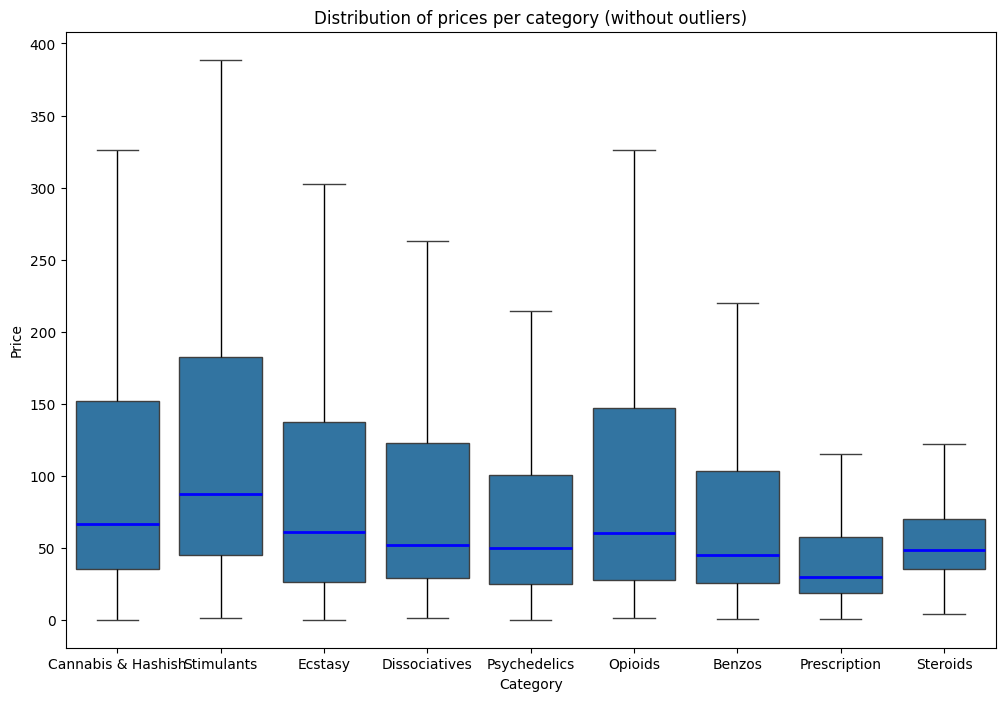

In [110]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='price', data=ab_full_drugs, whis=1.5, showfliers=False,
            medianprops={'color': 'blue', 'linewidth': 2},
            whiskerprops={'color': 'black', 'linewidth': 1},
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red', 'markeredgecolor': 'red'})

plt.title('Distribution of prices per category (without outliers)')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

In [111]:
ab_full_drugs['category_cat3'] = ab_full_drugs['category'] + "_"+ ab_full_drugs['cat3'].astype(str)

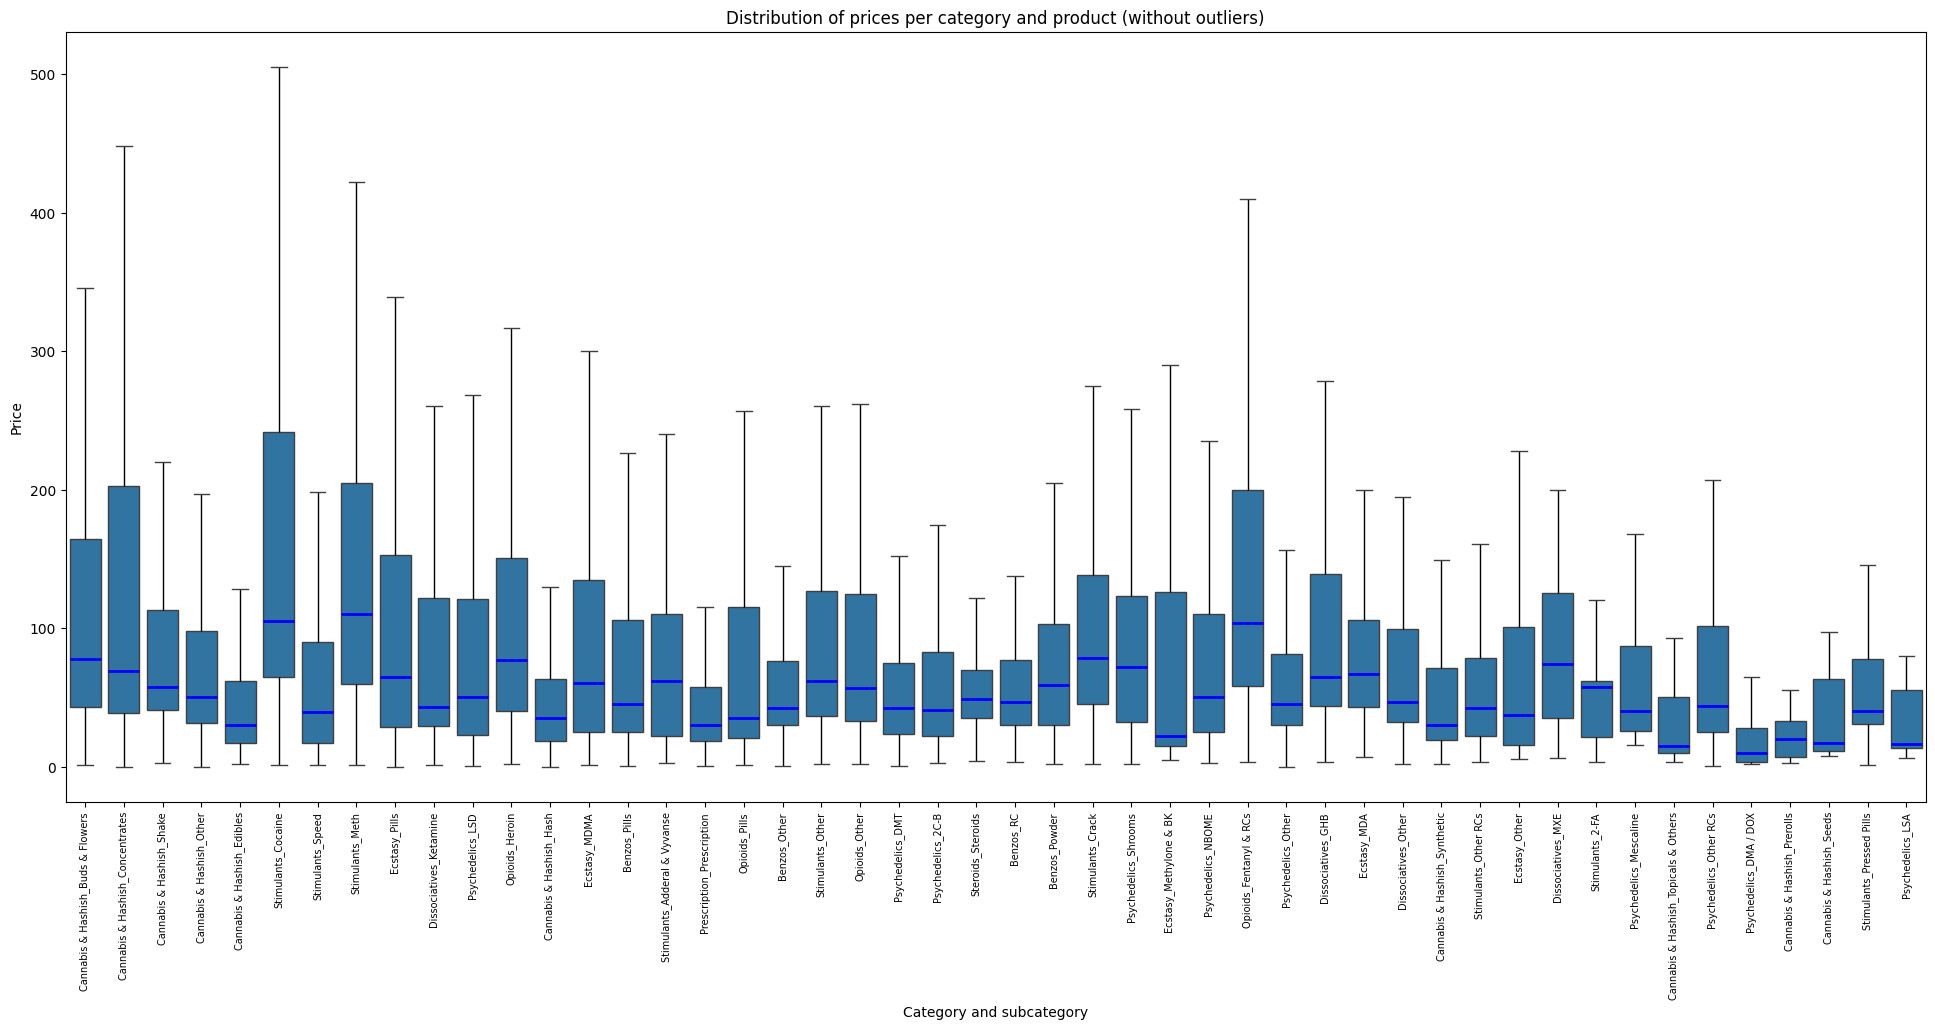

In [112]:
plt.figure(figsize=(24, 10))
sns.boxplot(x='category_cat3', y='price', data=ab_full_drugs, whis=1.5, showfliers=False,
            medianprops={'color': 'blue', 'linewidth': 2},
            whiskerprops={'color': 'black', 'linewidth': 1},
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red', 'markeredgecolor': 'red'})

plt.title('Distribution of prices per category and product (without outliers)')
plt.xlabel('Category and subcategory')
plt.ylabel('Price')
plt.xticks(rotation=90, size=7)
plt.show()

In [113]:
ab_full_drugs = ab_full_drugs.drop(columns=['category_cat3'])

The data appears to be mixed and skewed, with some very high values ​​in certain categories. Therefore, a multiple of the median may be a more appropriate choice in this case, as it will allow for more flexible adjustment of thresholds for different categories where skewness is significant.

Remove outliers in 'price': 5x median

In [114]:
def remove_extreme_outliers(data, column, upper_multiplier=5, lower_multiplier=0.2):
    upper_threshold = data.groupby(['category','cat3'])[column].transform(lambda x: upper_multiplier * x.median())
    lower_threshold = data.groupby(['category','cat3'])[column].transform(lambda x: lower_multiplier * x.median())
    filtered_data = data[(data[column] <= upper_threshold) & (data[column] >= lower_threshold)]


    return filtered_data

cleaned_data = remove_extreme_outliers(ab_full_drugs, 'price')

We can also check statistics about deleted data:

In [115]:
ab_full_drugs.shape[0]

915794

In [116]:
cleaned_data.shape[0]

777161

In [117]:
delete_n = ab_full_drugs.shape[0] - cleaned_data.shape[0]
delete_per = (delete_n/ab_full_drugs.shape[0])*100
print(f"Number of records which we deleted as outliers: {delete_n}" )
print(f"Which is: {delete_per}%")

Number of records which we deleted as outliers: 138633
Which is: 15.138011386840272%


In [118]:
def identify_extreme_outliers(data, column, upper_multiplier=5, lower_multiplier=0.2):
    upper_threshold = data.groupby(['category', 'cat3'])[column].transform(lambda x: upper_multiplier * x.median())
    lower_threshold = data.groupby(['category', 'cat3'])[column].transform(lambda x: lower_multiplier * x.median())
    outliers = data[(data[column] > upper_threshold) | (data[column] < lower_threshold)]

    return outliers

outliers_data = identify_extreme_outliers(ab_full_drugs, 'price')

stats = outliers_data['category'].value_counts().reset_index()
stats.columns = ['category', 'outliers_count']
stats['total_count'] = ab_full_drugs['category'].value_counts().reset_index(drop=True)
stats['percentage'] = (stats['outliers_count'] / stats['total_count']) * 100

stats

,category,outliers_count,total_count,percentage
0,Cannabis & Hashish,43000,288802,14.889094
1,Stimulants,24344,184491,13.195224
2,Ecstasy,17390,104380,16.660280
3,Benzos,16000,95540,16.746912
4,Psychedelics,15350,85206,18.015163
5,Opioids,13876,77790,17.837768
6,Prescription,5141,35252,14.583570
7,Dissociatives,3186,26850,11.865922
8,Steroids,346,17483,1.979065


Create new variable price to logarytmic:

In [119]:
cleaned_data.reset_index(drop=True, inplace=True)
cleaned_data.loc[:,'log_price'] = np.log1p(cleaned_data['price'])

<ipython-input-119-c76001fe4df2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.loc[:,'log_price'] = np.log1p(cleaned_data['price'])


Save data:

In [128]:
cleaned_data.to_csv(join(PROCESSED_DIR, "ab_drugs_dataset_cleaned_final.csv"), index=False)

## Descriptive statistics

In [121]:
cleaned_data.groupby(['category'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Benzos,61790.0,56.320217,42.861669,8.49,25.61,42.00,76.00,290.00
Cannabis & Hashish,245802.0,89.201393,72.545379,3.61,37.63,63.00,120.95,387.49
Dissociatives,23664.0,69.441368,53.211133,9.99,29.00,42.71,98.00,323.86
Ecstasy,86990.0,82.292722,68.468210,5.00,30.00,58.79,111.83,322.25
Opioids,81664.0,80.368898,75.653959,7.00,27.00,52.93,106.50,515.00
Prescription,30111.0,40.426132,29.571182,6.00,20.00,30.00,52.09,150.00
Psychedelics,69856.0,70.257507,53.699357,2.00,30.00,50.95,95.72,360.00
Steroids,17137.0,53.855606,28.220915,10.00,34.96,48.10,68.96,240.00
Stimulants,160147.0,118.401816,102.287927,7.93,48.38,85.00,155.00,550.00


In [122]:
cleaned_data.groupby(['category','cat3'])['price'].describe()

count        mean         std    min  \
category           cat3                                                         
Benzos             Other                4981.0   54.736471   35.116704   8.49   
                   Pills               52946.0   55.946264   43.079771   9.00   
                   Powder               3185.0   64.698433   49.676830  12.00   
                   RC                    678.0   57.800059   38.652931   9.90   
Cannabis & Hashish Buds & Flowers     150818.0  101.161395   74.162015  15.50   
                   Concentrates        39285.0   94.777926   82.279526  13.84   
                   Edibles              8689.0   39.008228   27.477059   6.00   
                   Hash                28944.0   44.465717   33.079513   7.09   
                   Other               11978.0   68.177748   49.941093  10.00   
                   Prerolls               75.0   21.054133   15.932096   4.36   
                   Seeds                  11.0   17.588182   11.208189   8.00   
                   Shake                5299.0   89.809941   59.921856  12.00   
                   Synthetic             594.0   38.334899   33.314907   6.00   
                   Topicals & Others     109.0   23.240183   19.064510   3.61   
Dissociatives      GHB                  2382.0   98.092515   70.791242  13.14   
                   Ketamine            19923.0   65.096541   49.341751   9.99   
                   MXE                   921.0   92.833594   55.553298  15.13   
                   Other                 438.0   62.068584   44.544107  10.00   
Ecstasy            MDA                  1182.0   83.821582   56.329532  13.81   
                   MDMA                54079.0   78.208361   66.151140  12.11   
                   Methylone & BK        462.0   24.112273   21.979172   5.00   
                   Other                1663.0   49.298244   41.456163   7.43   
                   Pills               29604.0   92.454194   72.822735  12.89   
Opioids            Fentanyl & RCs      10368.0  135.045456  108.500378  20.80   
                   Heroin              31399.0   98.427136   76.543492  15.53   
                   Other                9038.0   71.404961   58.545379  11.33   
                   Pills               30859.0   46.249805   41.262707   7.00   
Prescription       Prescription        30111.0   40.426132   29.571182   6.00   
Psychedelics       2C-B                 7109.0   55.107102   35.634922   8.26   
                   DMA / DOX             787.0   12.173799   11.884751   2.00   
                   DMT                 13761.0   51.832727   35.311311   8.61   
                   LSA                     9.0   35.877778   29.069422   6.00   
                   LSD                 31881.0   78.750201   59.565345  10.00   
                   Mescaline             413.0   56.823341   40.118852  15.50   
                   NBOME                3064.0   64.820881   54.384663  10.00   
                   Other                 789.0   58.955234   38.860402   9.75   
                   Other RCs             808.0   60.190359   40.657738   9.91   
                   Shrooms             11235.0   85.902476   56.143340  14.46   
Steroids           Steroids            17137.0   53.855606   28.220915  10.00   
Stimulants         2-FA                  272.0   71.131324   46.531728  11.63   
                   Adderal & Vyvanse    9224.0   77.469729   62.245280  12.35   
                   Cocaine             79577.0  145.404727  108.717649  21.00   
                   Crack                2739.0   94.335798   67.914738  16.42   
                   Meth                29061.0  139.940924  111.973999  22.00   
                   Other                6059.0   83.801855   65.055087  12.50   
                   Other RCs            4033.0   51.337136   38.813688   8.94   
                   Pressed Pills         271.0   56.367306   40.215591   8.50   
                   Speed               28911.0   55.398034   45.258600  

In [123]:
cleaned_data.groupby('category')['weight_in_gram'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Benzos,61790.0,3.92,110.84,0.00,0.05,0.20,0.40,9000.0
Cannabis & Hashish,245802.0,17.34,291.67,0.00,3.00,7.00,14.00,50000.0
Dissociatives,23664.0,240.46,3796.54,0.01,1.00,1.00,3.50,65000.0
Ecstasy,86990.0,11.22,135.35,0.00,1.00,2.50,7.00,22500.0
Opioids,81664.0,4.55,49.07,0.00,0.09,0.50,1.68,3350.0
Prescription,30111.0,6.75,106.96,0.00,0.20,1.00,2.40,5000.0
Psychedelics,69856.0,10.65,108.92,0.00,0.00,0.09,1.00,3500.0
Steroids,17137.0,139.17,581.89,0.00,1.00,1.50,3.00,10000.0
Stimulants,160147.0,14.42,230.01,0.00,1.00,1.00,3.50,7400.0


In [124]:
cleaned_data['emo_une'].value_counts()

emo_une
0    586502
1    190659
Name: count, dtype: int64

In [125]:
cleaned_data['itemid'].nunique()

29993

In [126]:
cleaned_data.describe()

,itemid,price,t_communication,t_payment,t_refund,t_price,t_value,t_shipping,t_product,t_feedback,t_vendor,t_generic,t_overall,emo_une,n_sold,vendor_level,trust_level,weight_in_gram,log_price
count,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000,777161.000000
mean,130273.890050,85.929243,0.052550,0.031031,0.004896,0.042434,0.072356,0.570300,0.525262,0.006844,0.208730,0.111658,0.261682,0.245328,767.872374,6.968826,6.454453,22.110708,4.131257
std,91675.417096,76.928454,0.223134,0.173401,0.069800,0.201577,0.259076,0.495034,0.499362,0.082446,0.406401,0.314945,0.439551,0.430282,1151.575797,2.139544,1.583593,700.570591,0.823812
min,162.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000010,1.098612
25%,51717.000000,32.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,6.000000,5.000000,0.500000,3.523710
50%,107884.000000,59.990000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.000000,7.000000,6.000000,2.000000,4.110710
75%,197562.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,952.000000,9.000000,7.000000,7.000000,4.709530
max,371908.000000,550.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8490.000000,10.000000,10.000000,65000.000000,6.311735


Verification if there are a comments which were not assigned to any topic



In [60]:
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value',
          't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

count_zeros = (cleaned_data[topics] == 0).all(axis=1).sum()

In [63]:
cleaned_data[(cleaned_data[topics] == 0).all(axis=1)]['comment']

18                                                   100 TY
67                                                Thanks <3
100                                        thanks very much
158              holy shit guys. i actually travelled time.
244                                                 Thanks!
                                ...                        
854908                                              Thanks!
854931    VielÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃ...
854935                       The feedback is positive. 1 DD
854943    Thank you for sharing the healing spirit with ...
854971                                       fast n furious
Name: comment, Length: 29529, dtype: object

In [64]:
(count_zeros/cleaned_data[topics].shape[0])*100

3.6298709280885064

# Automatic Methods Prediction–Robustness Checks

To ensure good performance of automatic text methods, we follow the literature
recommendations of sampling texts so that different types of texts are represented (Japkowicz
2000). We are thus confident that our methods are well equipped to replicate manual coding
on positive, neutral and negative texts, both in terms of motive cues and text polarity.

In this section, we compare the proportions of motive cues in manually annotated AlphaBay
dataset to the proportions in feedback automatically coded by the DeBERTa model. Since we
oversample the texts following neutral and negative quantitative ratings in our sample, we
provide the comparison per rating category in Table.

In [4]:
ab_full = pd.read_csv(join(PROCESSED_DIR, "full_dataset.csv"), encoding='latin1')
sample_prediciton = pd.read_csv(join(PROCESSED_DIR, "SamplePrediction/DeBERTa_sample_predicted_final.csv"), encoding='latin1')

First we need to filter our main dataset:

In [5]:
ab_relevant_feedback = ab_full[ab_full['global_id'].isin(sample_prediciton['global_id'])]

Now we can merge both dataset so we will have official rating per comements

In [6]:
sample_merge = pd.merge(sample_prediciton,
                        ab_relevant_feedback.loc[:,['global_id','rating']],
                        on='global_id')

In [7]:
sample_merge.columns

Index(['comment', 'global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'pred_t_communication',
       'pred_t_payment', 'pred_t_refund', 'pred_t_price', 'pred_t_value',
       'pred_t_shipping', 'pred_t_product', 'pred_t_feedback', 'pred_t_vendor',
       'pred_t_generic', 'pred_t_overall', 'emo_une', 'pred_emo_une',
       'rating'],
      dtype='object')

## Emotional

In [8]:
manual_shares_emo = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Emotional': round((x['emo_une'] == 1).mean() * 100, 1),
                         'Unemotional': round((x['emo_une'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
manual_shares_emo

,0,1,2
rating,Negative,Neutral,Positive
Emotional,31.9,7.1,26.2
Unemotional,68.1,92.9,73.8


In [9]:
prediction_shares_emo = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Emotional': round((x['pred_emo_une'] == 1).mean() * 100, 1),
                         'Unemotional': round((x['pred_emo_une'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
prediction_shares_emo

,0,1,2
rating,Negative,Neutral,Positive
Emotional,30.6,14.3,32.5
Unemotional,69.4,85.7,67.5


## Topics

In [10]:
def calculate_means(df, cols, prefix=""):
    if prefix:
        cols = [prefix + col for col in cols]

    agg_dict = {col: lambda x: (x == 1).mean() * 100 for col in cols}

    result = df.groupby('rating').agg(agg_dict).round(1)
    return result

col_topic = ['t_communication', 't_payment', 't_refund',
             't_price', 't_value', 't_shipping', 't_product', 't_feedback',
             't_vendor', 't_generic', 't_overall']

# Calculate manual shares
manual_shares_topic = calculate_means(sample_merge, cols= col_topic).transpose()
# Calculate prediction shares with '_pred' suffix
prediction_shares_topic = calculate_means(sample_merge, cols= col_topic, prefix = "pred_").transpose()

In [11]:
manual_shares_topic

rating,Negative,Neutral,Positive
t_communication,43.1,0.0,8.8
t_payment,4.2,0.0,2.5
t_refund,11.1,10.7,1.2
t_price,0.0,0.0,6.2
t_value,4.2,7.1,6.2
t_shipping,59.7,42.9,57.5
t_product,27.8,64.3,48.8
t_feedback,1.4,7.1,1.2
t_vendor,25.0,7.1,16.2
t_generic,0.0,0.0,11.2


In [12]:
prediction_shares_topic

rating,Negative,Neutral,Positive
pred_t_communication,51.4,0.0,7.5
pred_t_payment,5.6,3.6,1.2
pred_t_refund,12.5,10.7,0.0
pred_t_price,0.0,3.6,7.5
pred_t_value,2.8,7.1,7.5
pred_t_shipping,58.3,42.9,58.8
pred_t_product,30.6,64.3,51.2
pred_t_feedback,2.8,3.6,1.2
pred_t_vendor,26.4,7.1,18.8
pred_t_generic,2.8,0.0,15.0


#Analysis of Product Categories and Comment Topics


Firs we need to load our data

In [3]:
cleaned_data = pd.read_csv(join(PROCESSED_DIR,"ab_drugs_dataset_cleaned_final.csv"), encoding='latin1')

## Logistic regression

In [25]:
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value', 't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']
categories = cleaned_data['category'].unique()

# Reshape the data to create 11 copies of each row
reshaped_data = pd.concat([cleaned_data[['category','seller'] + topics ].copy()] * len(topics), ignore_index=True)
reshaped_data = reshaped_data.sort_values(by=['category']).reset_index(drop=True)

# Create dummy variables for topics and the dependent variable "mentioned"
dummy_columns = pd.DataFrame()
mentioned_column = pd.Series(0, index=reshaped_data.index)

for i, topic in enumerate(topics):
    dummy_col = pd.Series(0, index=reshaped_data.index)
    dummy_col.iloc[i::len(topics)] = 1
    dummy_columns[f'dummy_{topic}'] = dummy_col
    mentioned_column.iloc[i::len(topics)] = reshaped_data.loc[i::len(topics), topic].values

reshaped_data['mentioned'] = mentioned_column

# Create category variables and interaction terms
interaction_terms = pd.DataFrame()

for category in categories:
    category_col = (reshaped_data['category'] == category).astype(int)
    reshaped_data[f'category_{category}'] = category_col

    for topic in topics:
        interaction_term = f'category_{category}*dummy_{topic}'
        interaction_terms[interaction_term] = category_col.values * dummy_columns[f'dummy_{topic}'].values

# Concatenate all new columns with reshaped_data
reshaped_data = pd.concat([reshaped_data, interaction_terms], axis=1)

# Prepare data for training
X = reshaped_data[interaction_terms.columns].values
y = reshaped_data['mentioned'].values

In [26]:
# Run logistic regression without an intercept
model = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.329770
         Iterations 10


In [27]:
print(model.summary(xname=interaction_terms.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              8548771
Model:                          Logit   Df Residuals:                  8548672
Method:                           MLE   Df Model:                           98
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                  0.2805
Time:                        01:31:25   Log-Likelihood:            -2.8191e+06
converged:                       True   LL-Null:                   -3.9184e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
category_Cannabis & Hashish*dummy_t_communication    -3.1821      0.010   -308.577      0.000      -3.202      -3.162
category_Canna

In [32]:
# Calculate cluster-robust standard errors using the cov_cluster function
cluster_cov = cov_cluster(model, sellers_numeric)
cluster_bse = np.sqrt(np.diag(cluster_cov))

# Extract coefficients
coef = model.params

# Calculate z-values and p-values
z_values = coef / cluster_bse
p_values = 2 * (1 - norm.cdf(np.abs(z_values)))

# Calculate confidence intervals
conf_int_025 = coef - 1.96 * cluster_bse
conf_int_975 = coef + 1.96 * cluster_bse

# Create DataFrame with results
results_df = pd.DataFrame({
    'topic': [term.split('*dummy_')[1] for term in interaction_terms.columns],
    'coef': coef,
    'std err': cluster_bse,
    'z': z_values,
    'P>|z|': p_values,
    '[0.025': conf_int_025,
    '0.975]': conf_int_975,
    'category': [term.split('*')[0] for term in interaction_terms.columns],
})

# Transform coefficients to probabilities
results_df['probability'] = np.exp(results_df['coef']) / (1 + np.exp(results_df['coef']))

# Calculate error for probabilities using delta method, considering cluster-robust standard errors
results_df['error'] = cluster_bse * results_df['probability'] * (1 - results_df['probability'])


In [33]:
results_df

,topic,coef,std err,z,P>|z|,[0.025,0.975],category,probability,error
0,t_communication,-3.182096,0.071251,-44.660652,0.0,-3.321747,-3.042445,category_Cannabis & Hashish,0.039845,0.002726
1,t_payment,-3.465396,0.166316,-20.836265,0.0,-3.791375,-3.139418,category_Cannabis & Hashish,0.030313,0.004889
2,t_refund,-5.393832,0.150776,-35.773721,0.0,-5.689354,-5.098310,category_Cannabis & Hashish,0.004524,0.000679
3,t_price,-3.193857,0.062910,-50.768451,0.0,-3.317161,-3.070553,category_Cannabis & Hashish,0.039398,0.002381
4,t_value,-2.192496,0.063207,-34.687762,0.0,-2.316381,-2.068611,category_Cannabis & Hashish,0.100426,0.005710
...,...,...,...,...,...,...,...,...,...,...
94,t_product,-0.579246,0.043273,-13.385847,0.0,-0.664062,-0.494431,category_Steroids,0.359106,0.009959
95,t_feedback,-4.689994,0.144354,-32.489635,0.0,-4.972927,-4.407061,category_Steroids,0.009103,0.001302
96,t_vendor,-1.147210,0.050916,-22.531295,0.0,-1.247006,-1.047414,category_Steroids,0.240999,0.009314
97,t_generic,-1.816347,0.099688,-18.220379,0.0,-2.011735,-1.620959,category_Steroids,0.139873,0.011993


In [36]:
results_df.to_csv(join(PROJECT_DIR, "Results/mlogit_topic_category_final.csv"), index=False)

Evaluation:

AUC: 0.8541
Accuracy: 0.8499
Precision: 0.5708
Recall: 0.5035
F1 Score: 0.5351
Confusion Matrix:
[[6526845  555258]
 [ 728162  738506]]


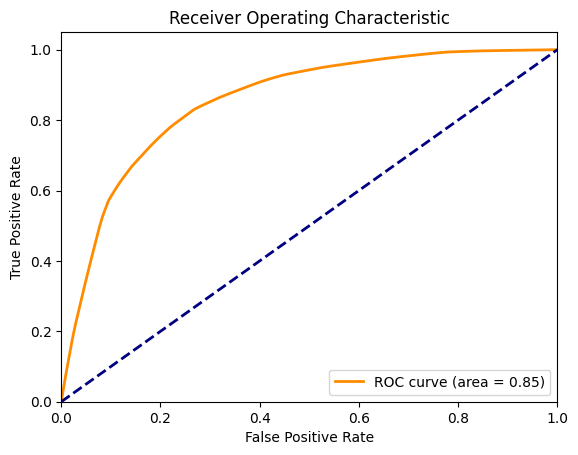

In [35]:
def evaluate_model_statsmodels(model, X, y):
    # Generate predictions
    predictions = model.predict(X)

    # Convert predictions to binary outcomes
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    auc = roc_auc_score(y, predictions)
    accuracy = accuracy_score(y, predicted_classes)
    precision = precision_score(y, predicted_classes)
    recall = recall_score(y, predicted_classes)
    f1 = f1_score(y, predicted_classes)
    conf_matrix = confusion_matrix(y, predicted_classes)

    # Print metrics
    print(f'AUC: {auc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y, predictions)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model on the data
evaluate_model_statsmodels(model, X, y)

##  Correspondence Analysis

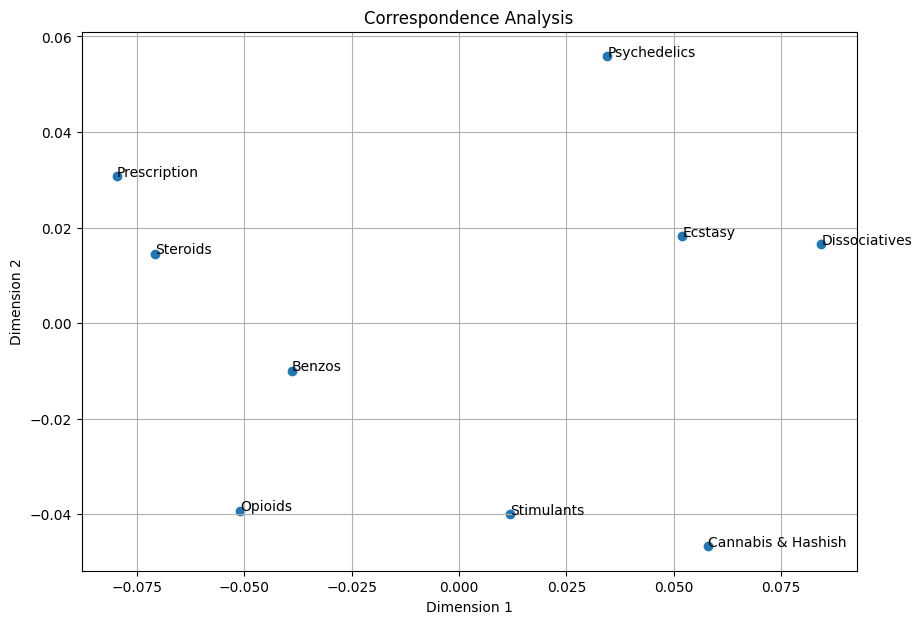

In [34]:
# Create a contingency table
contingency_table = pd.crosstab(cleaned_data['category'], [cleaned_data['t_communication'], cleaned_data['t_payment'], cleaned_data['t_refund'],
                                                            cleaned_data['t_price'], cleaned_data['t_value'], cleaned_data['t_shipping'],
                                                            cleaned_data['t_product'], cleaned_data['t_feedback'], cleaned_data['t_vendor'],
                                                            cleaned_data['t_generic'], cleaned_data['t_overall']])

# Perform Correspondence Analysis using PCA on the standardized contingency table
pca = PCA(n_components=2)
contingency_table_standardized = contingency_table.div(contingency_table.sum(axis=1), axis=0)  # Normalize rows
coordinates = pca.fit_transform(contingency_table_standardized)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(coordinates[:, 0], coordinates[:, 1])

# Annotate points with category names
for i, category in enumerate(contingency_table.index):
    plt.annotate(category, (coordinates[i, 0], coordinates[i, 1]))

plt.title('Correspondence Analysis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

Cannabis & Hashish, Stimulants, and Opioids: These categories are relatively close to each other on Dimension 2, suggesting that they have similar comment profiles. For example, they may have a similar percentage of comments about price, shipping, etc.

Psychedelics: This category is clearly separated on Dimension 2, suggesting that its comment profile is different from other categories.

Ecstasy and Dissociatives: These categories are close to each other, suggesting a similarity in comment profiles.

# Shares of topics occurrences per quantitative feedback rating

Function to calculate percentage shares for each topic, rating, and emotional value


In [12]:
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value',
          't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

topic_mapping = {
    't_communication': 'Communication',
    't_payment': 'Payment / finalise early',
    't_refund': 'Refunds',
    't_price': 'Extras / goodies',
    't_value': 'Value for money',
    't_shipping': 'Delivery / stealth',
    't_product': 'Product quality',
    't_feedback': 'Leaving / changing feedback',
    't_vendor': 'Vendor quality',
    't_generic': 'Generic rating',
    't_overall': 'Overall experience'
}

In [13]:
# Function to calculate percentage shares for each topic, rating, and emotional value
def calculate_percentage(df, topics):
    results = []

    # Total count of the entire dataset
    total_count_all = len(df)

    # Iterate through each topic
    for topic in topics:
        # Overall percentage for the entire dataset
        total_count_topic = df[topic].sum()
        percentage_all_total = (total_count_topic / total_count_all) * 100
        results.append([topic, 'ALL', 'All', percentage_all_total])

        # Group data by 'rating' and calculate count for the current topic
        grouped_all = df.groupby('rating')[topic].sum()

        # Calculate percentage share for each rating for the entire dataset
        for rating, count in grouped_all.items():
            total_count_rating_all = df[df['rating'] == rating][topic].sum()
            percentage_rating_all = (count / total_count_topic) * 100
            results.append([topic, 'ALL', rating, percentage_rating_all])

        # Iterate through emotional values (0 and 1)
        for emotional_value in [0, 1]:
            # Filter data for the current emotional value
            filtered_df = df[df['emo_une'] == emotional_value]

            # Total count for the current emotional value
            total_count_emotional = len(filtered_df)

            # Total count for the current topic and emotional value
            total_count_topic_emotional = filtered_df[topic].sum()
            percentage_all_emotional = (total_count_topic_emotional / total_count_emotional) * 100
            results.append([topic, emotional_value, 'All', percentage_all_emotional])

            # Group data by 'rating' and calculate count for the current topic
            grouped = filtered_df.groupby('rating')[topic].sum()

            # Calculate percentage share for each rating
            for rating, count in grouped.items():
                total_count_rating = filtered_df[filtered_df['rating'] == rating][topic].sum()
                percentage_rating = (count / total_count_topic_emotional) * 100
                results.append([topic, emotional_value, rating, percentage_rating])

    # Create a DataFrame from the results list
    final_result = pd.DataFrame(results, columns=['topic', 'emo_une', 'rating', 'share'])

    return final_result

# Calculate percentage shares for the given DataFrame and topics
percentage_shares_emotion = calculate_percentage(cleaned_data[['rating', 'emo_une'] + topics], topics)

percentage_shares_emotion = percentage_shares_emotion.round(2)
percentage_shares_emotion['topic'] = percentage_shares_emotion['topic'].map(topic_mapping)
percentage_shares_emotion['emo_une'] = percentage_shares_emotion['emo_une'].replace({0: 'Unemotional',
                                                                                         1: 'Emotional',
                                                                                         'ALL': 'ALL'})

In [14]:
percentage_shares_emotion[percentage_shares_emotion['topic']=='Communication']

,topic,emo_une,rating,share
0,Communication,ALL,All,5.26
1,Communication,ALL,Negative,13.16
2,Communication,ALL,Neutral,3.87
3,Communication,ALL,Positive,82.98
4,Communication,Unemotional,All,5.27
5,Communication,Unemotional,Negative,11.71
6,Communication,Unemotional,Neutral,4.65
7,Communication,Unemotional,Positive,83.65
8,Communication,Emotional,All,5.22
9,Communication,Emotional,Negative,17.66


Save the data to visualize them better in R:

In [15]:
percentage_shares_emotion.to_csv(join(PROJECT_DIR, "Results/df_shares_topic.csv"), index=False)

## Performing Chi-square tests

In [16]:
results_chi2 = []
for topic in topics:
    # Contingency table for the topic and emotional variable
    contingency_table = pd.crosstab(cleaned_data['emo_une'], cleaned_data[topic])

    # Chi-square test: Emotional vs. Unemotional comments
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    results_chi2.append({'Topic': topic, 'Comparison': 'Emotional vs Unemotional', 'Chi2': chi2, 'P-value': p_value})

results_chi2_df = pd.DataFrame(results_chi2)

In [17]:
results_chi2_df

,Topic,Comparison,Chi2,P-value
0,t_communication,Emotional vs Unemotional,0.697282,4.036984e-01
1,t_payment,Emotional vs Unemotional,334.056289,1.257009e-74
2,t_refund,Emotional vs Unemotional,61.107196,5.405023e-15
3,t_price,Emotional vs Unemotional,1035.992223,2.697682e-227
4,t_value,Emotional vs Unemotional,251.909694,9.956698e-57
5,t_shipping,Emotional vs Unemotional,7558.582764,0.000000e+00
6,t_product,Emotional vs Unemotional,378.548748,2.575866e-84
7,t_feedback,Emotional vs Unemotional,933.288098,5.695510e-205
8,t_vendor,Emotional vs Unemotional,24860.419183,0.000000e+00
9,t_generic,Emotional vs Unemotional,5646.424177,0.000000e+00


## Shares of topic by rating

This time we check shares of topic by rating in whole dataset. So the percentage of each individual ratings dont sum to a 100%

In [18]:
def calculate_percentage(x):
    return x.mean() * 100

overall_values = {
    'Communication': calculate_percentage(cleaned_data['t_communication']),
    'Payment / finalise early': calculate_percentage(cleaned_data['t_payment']),
    'Refunds': calculate_percentage(cleaned_data['t_refund']),
    'Extras / goodies': calculate_percentage(cleaned_data['t_price']),
    'Value for money': calculate_percentage(cleaned_data['t_value']),
    'Delivery / stealth': calculate_percentage(cleaned_data['t_shipping']),
    'Product quality': calculate_percentage(cleaned_data['t_product']),
    'Leaving / changing feedback': calculate_percentage(cleaned_data['t_feedback']),
    'Vendor quality': calculate_percentage(cleaned_data['t_vendor']),
    'Generic rating': calculate_percentage(cleaned_data['t_generic']),
    'Overall experience': calculate_percentage(cleaned_data['t_overall'])
}

# Convert overall values to a DataFrame
overall_values_df = pd.DataFrame(overall_values.items(), columns=['topic', 'share'])
overall_values_df['rating'] = 'All'

# Reorder columns to match the original table format
overall_values_df = overall_values_df[['rating', 'topic', 'share']]

# Round values
overall_values_df['share'] = round(overall_values_df['share'], 1)

In [19]:
barpred_or_cues = cleaned_data.groupby(['rating']).agg(
    **{
        'Communication': ('t_communication', calculate_percentage),
        'Payment / finalise early': ('t_payment', calculate_percentage),
        'Refunds': ('t_refund', calculate_percentage),
        'Extras / goodies': ('t_price', calculate_percentage),
        'Value for money': ('t_value', calculate_percentage),
        'Delivery / stealth': ('t_shipping', calculate_percentage),
        'Product quality': ('t_product', calculate_percentage),
        'Leaving / changing feedback': ('t_feedback', calculate_percentage),
        'Vendor quality': ('t_vendor', calculate_percentage),
        'Generic rating': ('t_generic', calculate_percentage),
        'Overall experienc': ('t_overall', calculate_percentage)
    })

# convert to long format
barpred_or_cues_long = (barpred_or_cues.reset_index()
                         .melt(id_vars=['rating'], var_name='topic', value_name='share'))

# round values
barpred_or_cues_long['share'] = round(barpred_or_cues_long['share'], 1)

In [20]:
final_rating_type = pd.concat([barpred_or_cues_long, overall_values_df], ignore_index=True)

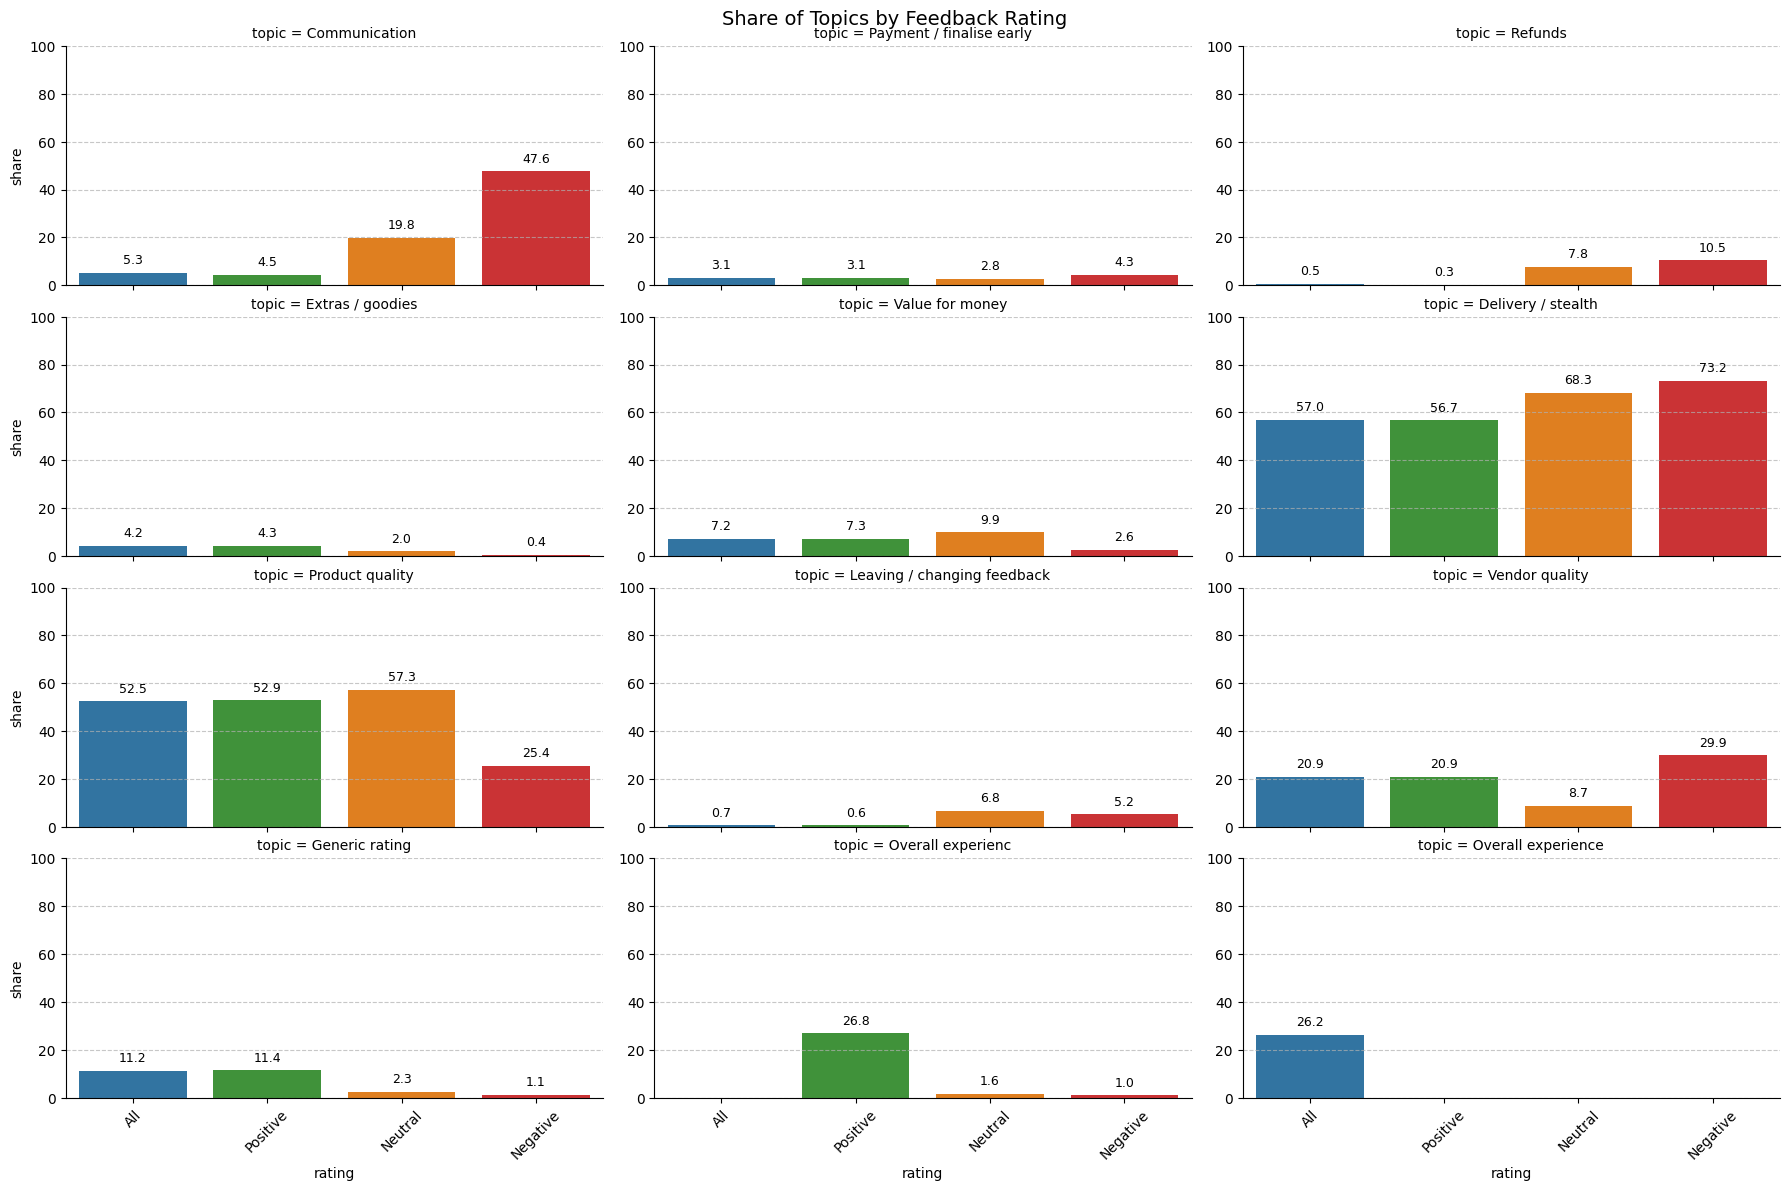

In [21]:
# Define the order of the categories
rating_order = ["All", "Positive", "Neutral", "Negative"]
final_rating_type['rating'] = pd.Categorical(final_rating_type['rating'], categories=rating_order, ordered=True)

# Set the color palette
palette = {"All": "#1F78B4", "Positive": "#33A02C", "Neutral": "#FF7F00", "Negative": "#E31A1C"}

# Create the FacetGrid for each topic
g = sns.FacetGrid(final_rating_type, col="topic", hue="rating", col_wrap=3, sharey=False, palette=palette, height=4, aspect=1.5)

# Map the barplot to the FacetGrid
g.map(sns.barplot, "rating", "share", order=rating_order)

# Customize the plot
g.set(ylim=(0, 100))  # Adjust the ylim value

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.subplots_adjust(top=1)
g.fig.suptitle('Share of Topics by Feedback Rating', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(bottom=0.3)

plt.show()

# Mixed-Effects Models

Firs we need to load our data

In [3]:
cleaned_data = pd.read_csv(join(PROCESSED_DIR,"ab_drugs_dataset_cleaned_final.csv"), encoding='latin1')

In [4]:
data = cleaned_data[['emo_une','log_price','weight_in_gram','category', 'shipping_category',
                    'payment_group', 'vendor_level_grouped', 'trust_level_grouped',
                    'seller', 'itemid', 'rating', 't_communication', 't_payment', 't_refund',
                    't_price', 't_value', 't_shipping', 't_product', 't_feedback',
                    't_vendor', 't_generic', 't_overall']].copy()

In [6]:
formula = (
    'emo_une ~ log_price + weight_in_gram + C(category) + '
    'C(rating, levels=["Positive", "Neutral", "Negative"]) + '
    'C(shipping_category) + '
    'C(payment_group, levels=["Escrow", "FE Listing 10-40%", "FE Listing 50-90%", " FE Listing 100%"]) + '
    'C(vendor_level_grouped, levels=["Low", "Medium", "High", "Highest"]) +'
    'C(trust_level_grouped, levels=["Low", "Medium", "High", "Highest"]) + t_communication + '
    't_payment + t_refund + t_price + t_value + t_shipping + t_product + '
    't_feedback + t_vendor + t_generic + t_overall'
)

# Define the mixed effects model
model = smf.mixedlm(formula, data, groups=data['seller'], re_formula="~1",
                    vc_formula={"itemid": "0 + C(itemid)"})
result = model.fit(reml=False, method='powell') #other method lbfgs


In [6]:
print(result.summary())

                                                              Mixed Linear Model Regression Results
Model:                                                MixedLM                                   Dependent Variable:                                   emo_une     
No. Observations:                                     777161                                    Method:                                               ML          
No. Groups:                                           3763                                      Scale:                                                0.1711      
Min. group size:                                      1                                         Log-Likelihood:                                       -419142.1458
Max. group size:                                      28974                                     Converged:                                            Yes         
Mean group size:                                      206.5                          

In [7]:
# Calculate cluster-robust standard errors manually
X = result.model.exog
y = data['emo_une'].values
residuals = result.resid
num_clusters = data['seller'].nunique()
clusters = data['seller'].values

# Clustered sandwich estimator
def cluster_robust_cov(X, residuals, clusters):
    M = X.shape[1]
    bread = np.linalg.inv(X.T @ X)
    meat = np.zeros((M, M))
    unique_clusters = np.unique(clusters)
    cluster_count = len(unique_clusters)

    for cluster in unique_clusters:
        cluster_mask = clusters == cluster
        Xc = X[cluster_mask]
        residuals_c = residuals[cluster_mask]
        meat += (Xc.T @ np.outer(residuals_c, residuals_c) @ Xc)

    meat *= cluster_count / (cluster_count - 1)
    clustered_cov = bread @ meat @ bread
    return clustered_cov

# Calculate the clustered covariance matrix
clustered_cov_matrix = cluster_robust_cov(X, residuals, clusters)

# Extract cluster-robust standard errors
clustered_se = np.sqrt(np.diag(clustered_cov_matrix))

# Extract coefficients
fixed_effects = result.fe_params

# Calculate cluster-robust confidence intervals
lower_conf_int = fixed_effects - 1.96 * clustered_se
upper_conf_int = fixed_effects + 1.96 * clustered_se
conf_int = np.array([lower_conf_int, upper_conf_int]).T

# Convert coefficients to odds ratios
odds_ratios = np.exp(fixed_effects)
conf_int_odds_ratios = np.exp(conf_int)

# Extract p-values from the model
p_values = result.pvalues[:-2]

In [8]:
# Create final results DataFrame
results_df = pd.DataFrame({
    'ODS Ratio': odds_ratios,
    'Lower 95%': conf_int_odds_ratios[:, 0],
    'Upper 95%': conf_int_odds_ratios[:, 1],
    'P>|z|': p_values
})

# Format the numbers to have at most two decimal places and normal notation
results_df['ODS Ratio'] = results_df['ODS Ratio'].astype(float).map('{:.5f}'.format)
results_df['Lower 95%'] = results_df['Lower 95%'].astype(float).map('{:.5f}'.format)
results_df['Upper 95%'] = results_df['Upper 95%'].astype(float).map('{:.5f}'.format)
results_df['P>|z|'] = results_df['P>|z|'].map('{:.5f}'.format)

results_df

,ODS Ratio,Lower 95%,Upper 95%,P>|z|
Intercept,1.20038,1.18749,1.21341,0.00000
C(category)[T.Cannabis & Hashish],1.01124,1.00899,1.01349,0.00626
C(category)[T.Dissociatives],1.00439,1.00078,1.00802,0.46758
C(category)[T.Ecstasy],1.00858,1.00605,1.01111,0.05020
C(category)[T.Opioids],1.02532,1.02172,1.02892,0.00000
C(category)[T.Prescription],0.98697,0.98324,0.99072,0.00567
C(category)[T.Psychedelics],0.99881,0.99609,1.00154,0.80301
C(category)[T.Steroids],0.96625,0.96295,0.96955,0.00001
C(category)[T.Stimulants],1.00855,1.00594,1.01116,0.03285
"C(rating, levels=[""Positive"", ""Neutral"", ""Negative""])[T.Neutral]",0.94059,0.93280,0.94843,0.00000


Validation of the manual cluster-robust standard errors calculation:

In [17]:
from statsmodels.stats.sandwich_covariance import cov_cluster

# Extract residuals and explanatory variables from the mixed effects model
residuals = result.resid
X = result.model.exog
clusters = data['seller'].values

# Fit an OLS model using the same explanatory variables
ols_model = sm.OLS(residuals, X)
ols_result = ols_model.fit()

# Calculate cluster-robust standard errors using cov_cluster
clustered_cov = cov_cluster(ols_result, clusters)
clustered_se = np.sqrt(np.diag(clustered_cov))

# Extract coefficients from the mixed effects model
fixed_effects = result.fe_params

# Calculate cluster-robust confidence intervals
lower_conf_int = fixed_effects - 1.96 * clustered_se
upper_conf_int = fixed_effects + 1.96 * clustered_se
conf_int = np.array([lower_conf_int, upper_conf_int]).T

# Convert coefficients to odds ratios
odds_ratios = np.exp(fixed_effects)
conf_int_odds_ratios = np.exp(conf_int)

# Extract p-values from the mixed effects model
p_values = result.pvalues[:len(fixed_effects)]

# Create the final DataFrame
results_df_val = pd.DataFrame({
    'ODS Ratio': odds_ratios,
    'Lower 95%': conf_int_odds_ratios[:, 0],
    'Upper 95%': conf_int_odds_ratios[:, 1],
    'P>|z|': p_values
})

# Format the numbers to have at most two decimal places and normal notation
results_df_val['ODS Ratio'] = results_df_val['ODS Ratio'].astype(float).map('{:.5f}'.format)
results_df_val['Lower 95%'] = results_df_val['Lower 95%'].astype(float).map('{:.5f}'.format)
results_df_val['Upper 95%'] = results_df_val['Upper 95%'].astype(float).map('{:.5f}'.format)
results_df_val['P>|z|'] = results_df_val['P>|z|'].map('{:.5f}'.format)

results_df_val

,ODS Ratio,Lower 95%,Upper 95%,P>|z|
Intercept,1.20038,1.18749,1.21341,0.00000
C(category)[T.Cannabis & Hashish],1.01124,1.00899,1.01349,0.00626
C(category)[T.Dissociatives],1.00439,1.00078,1.00802,0.46758
C(category)[T.Ecstasy],1.00858,1.00605,1.01111,0.05020
C(category)[T.Opioids],1.02532,1.02172,1.02892,0.00000
C(category)[T.Prescription],0.98697,0.98324,0.99072,0.00567
C(category)[T.Psychedelics],0.99881,0.99609,1.00154,0.80301
C(category)[T.Steroids],0.96625,0.96295,0.96955,0.00001
C(category)[T.Stimulants],1.00855,1.00594,1.01116,0.03285
"C(rating, levels=[""Positive"", ""Neutral"", ""Negative""])[T.Neutral]",0.94059,0.93280,0.94843,0.00000


Calculate GVIF for each predictor variable

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF and adjust for GVIF for categorical variables
def calculate_gvif(model, data):
    exog_names = model.exog_names
    exog = model.exog

    gvif_data = pd.DataFrame()
    gvif_data["Variable"] = exog_names

    # Calculate VIF for numerical predictors
    gvif_data["GVIF"] = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

    # Adjust VIF for categorical predictors
    for var in data.select_dtypes(include=['category', 'object']).columns:
        if var in exog_names:
            levels = len(data[var].astype('category').cat.categories)
            if levels > 1:
                # Sum VIFs for all dummy variables of the categorical variable
                gvif = gvif_data[gvif_data["Variable"].str.contains(f"C\\({var}\\)[T.")] ["GVIF"].sum()
                # Remove individual VIF entries for dummy variables
                gvif_data = gvif_data[~gvif_data["Variable"].str.contains(f"C\\({var}\\)[T.")]
                # Add a single entry for the categorical variable with summed GVIF
                gvif_data = gvif_data.append({"Variable": f"GVIF_{var}", "GVIF": gvif}, ignore_index=True)

    return gvif_data

gvif_df = calculate_gvif(result.model, data)
gvif_df

,Variable,GVIF
0,Intercept,156.936137
1,C(category)[T.Cannabis & Hashish],3.684821
2,C(category)[T.Dissociatives],1.374068
3,C(category)[T.Ecstasy],2.217349
4,C(category)[T.Opioids],2.155965
5,C(category)[T.Prescription],1.454902
6,C(category)[T.Psychedelics],2.018987
7,C(category)[T.Steroids],1.267976
8,C(category)[T.Stimulants],3.065251
9,"C(rating, levels=[""Positive"", ""Neutral"", ""Nega...",1.027732


Allmost all GVIF indices are well below the threshold of 10, which means that there is no serious multiple multicollinearity problem in this model. Only for trust level valuers vere higher.


Evaluate the Goodness of Fit

In [10]:
aic = result.aic
bic = result.bic
llf = result.llf

# Fit a null model (intercept only)
null_model = smf.mixedlm('emo_une ~ 1', data, groups=data['seller'], re_formula="~1",
                         vc_formula={"itemid": "0 + C(itemid)"})
null_result = null_model.fit(reml=False, method='powell')
null_llf = null_result.llf

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
from scipy.stats import chi2

llr = -2 * (null_llf - llf)
llr_pvalue = chi2.sf(llr, df=1)

goodness_of_fit = {
    "AIC": aic,
    "BIC": bic,
    "Log-Likelihood": llf,
    "LLR": llr,
    "LLR p-value": llr_pvalue
}

print(goodness_of_fit)

{'AIC': 838360.2915470842, 'BIC': 838799.7008540578, 'Log-Likelihood': -419142.1457735421, 'LLR': 41754.73241907917, 'LLR p-value': 0.0}


AUC and ROC Curve

In [12]:
# Predict probabilities
probabilities = result.predict()
fpr, tpr, thresholds = roc_curve(data['emo_une'], probabilities)
auc = roc_auc_score(data['emo_une'], probabilities)

print(auc)

0.6536618917349359


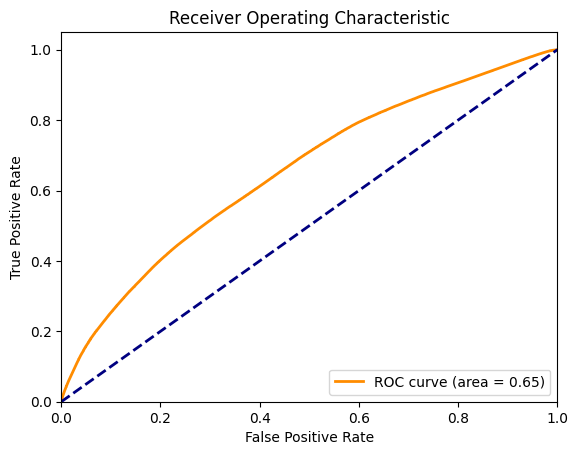

In [13]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

McFadden's R² and Nagelkerke's R²

In [14]:
# McFadden's R²
mcfadden_r2 = 1 - (llf / null_llf)

# Nagelkerke's R²
n = len(data)
nagelkerke_r2 = mcfadden_r2 / (1 - null_llf / n)

pseudo_r2 = {
    "McFadden's R²": mcfadden_r2,
    "Nagelkerke's R²": nagelkerke_r2
}

pseudo_r2

{"McFadden's R²": 0.047446455534322474, "Nagelkerke's R²": 0.03029422050919438}